In [1150]:
# %load_ext autoreload
# %reload_ext autoreload
# %autoreload 2

In [1151]:
import os
os.chdir('C:\\Users\\WDG1DCR\\Desktop\\my_projects\\data_analysis\\data_cleanse')
# os.chdir('C:\\Users\\gratten\\Documents\\python\\projects\\data_cleanse')

import pandas as pd
from prep import filter
from prep import sort
from plot import bar
from utility import generate

In [1152]:
fileName = 'filelist_8_12c'
df_og = pd.read_csv('datasets/' + fileName + '.csv', sep=';')

In [1153]:
df = filter.sld(df_og)

In [1154]:
dups = df[df.duplicated(['name_low'], keep=False)]
dups = dups.sort_values(['name_low'])

In [1155]:
# dups = dups.reset_index()
dups.reset_index(inplace=True, drop=True)

In [1156]:
dups.head()

,Name,Format,size,modified,created,path,name_low
0,#40 Chain.SLDASM,SLDASM,"92,370",06/19/2020 16:04:50,02/21/2016 22:51:10,R:\Doc\SolidWorks\CONVEYOR,#40 chain.sldasm
1,#40 CHAIN.SLDASM,SLDASM,"98,273",10/12/2018 13:43:23,02/22/2016 01:04:05,R:\Doc\SolidWorks\SolidWorks Palette\Palette P...,#40 chain.sldasm
2,#40 PIN RIVETED.SLDPRT,SLDPRT,"55,996",02/24/2017 15:31:59,02/22/2016 01:04:05,R:\Doc\SolidWorks\SolidWorks Palette\Palette P...,#40 pin riveted.sldprt
3,#40 PIN RIVETED.SLDPRT,SLDPRT,"52,842",11/20/2014 10:11:00,02/21/2016 23:05:11,R:\Doc\SolidWorks\HS4989 - QUAKER MAID MEATS,#40 pin riveted.sldprt
4,#40 PIN RIVETEDRev2.SLDPRT,SLDPRT,"52,722",11/19/2014 22:34:28,02/21/2016 22:59:28,R:\Doc\SolidWorks\HS4836-4 TWO FLAP CLOSER (ME...,#40 pin rivetedrev2.sldprt


In [1157]:
top_offenders = dups['path'].value_counts().index.to_list()

In [1158]:
# input: data (trimmed dups), num, cut off indicator (ie valCounts > 5)
# output: top_offenders list at level 2, in reguards to top_offender[num]
def get_top_offenders(dups, num, limit):
    
    # list of all files in directory top_offender[num]
    file_list = []
    for i in range(len(dups['path'])):
        if dups['path'][i] == top_offenders[num]:
            file_list.append(dups['name_low'].iloc[i])
    
    # dictionary of all files in directory top_offender[num] and all other associated paths
    # {filename: [path1, path2, etc], filename: [path1, path2, etc]}
    file_paths = {}
    for file in file_list:
        dups_trimmed = dups[(dups['name_low'] == file)]
        path_list = []
        for path in dups_trimmed['path']:
            path_list.append(path)
        file_paths[file] = path_list
        
    # create a list of all paths involved, merged together
    partner_paths = []
    for k, v in file_paths.items():
        for i in v:
            if i != top_offenders[num]:
                partner_paths.append(i)
    
    # create series and use value_counts
    partner_paths_series = pd.Series(partner_paths)
    val_count = partner_paths_series.value_counts()
    
    # trim top_offenders2 list, per user input (> x associated paths)
    top_offenders2 = []
    for i in range(len(val_count)):
        if val_count[i] > limit:
            top_offenders2.append(val_count.index[i])
    
    return top_offenders2, file_paths

In [1159]:
def build_data(offender, file_paths):
    
    # trim file_paths to only relevent files
    file_paths_trimmed = {}
    for k, v in file_paths.items():
        if offender in v:
            file_paths_trimmed[k] = v
            
    totalFiles = len(file_paths_trimmed.keys())
            
    occur_list = []
    for k, v in file_paths_trimmed.items():
        if len(v) not in occur_list:
                occur_list.append(len(v))

    occur_dict = {}
    for i in occur_list:
        occur_dict[i] = 0
        for v in file_paths_trimmed.values():
            if i == len(v):
                occur_dict[i] += 1
                
    num_list = []
    occur_list = []
    for i in range(len(occur_dict)):
        key = min(occur_dict.keys())
        num_list.append(key)
        value = occur_dict.pop(key)
        occur_list.append(value) 
            
    return num_list, occur_list, totalFiles

In [1160]:
def chart_em(num_list, occur_list, totalFiles, titleA, titleB, i):
    
    df = pd.DataFrame({'other paths':num_list, 'occurences':occur_list})
    title = f'{titleA}\n{titleB}\nTotal Files: {totalFiles}\nChart: {i}'
    ax = df.plot.bar(x='other paths', y='occurences', rot=0, figsize=(10, 4), title = title)

In [1161]:
def build_data2(num, chart_num, top_offenders, top_offenders2, file_paths):
    titleA = top_offenders[num]
    titleB = top_offenders2[chart_num]
    
    file_paths_trimmed = {}
    for k, v in file_paths.items():
        if titleB in v:
            if len(v) == quant: 
                file_paths_trimmed[k] = v
                
    path_list = []
    for v in file_paths_trimmed.values():
        for i in v:
            path_list.append(i)
            
    path_list = pd.Series(path_list)
    
    occurence_list = path_list.value_counts().to_list()
    
    path_list = path_list.value_counts().index.to_list()
    
    return occurence_list, path_list, file_paths_trimmed

In [1162]:
def chart_em2(list1, list2, titleA):
    df = pd.DataFrame({'other paths':list1, 'occurences':list2})
    title = f'{titleA}'
    ax = df.plot.barh(x='other paths', y='occurences', rot=0, figsize=(3, 7), title = title)

In [1163]:
def batch(files_to_remove, path):

    moveFileName = '8_12_files_to_remove.txt'
    
    # open file and write to it, then close
    moveFile = open(moveFileName, 'w')
    for i in files_to_remove:
        fileAndPath = path + '\\' + i
        fileAndPath = '"' + fileAndPath + '"'
        newLoc = 'C:/Users/wdg1dcr/Desktop/dupBackup/movedFiles'
        moveFile.write('move ' + fileAndPath + '*.* ' + newLoc + '\n')
    moveFile.close()

In [1164]:
def batch2(files_to_remove):
    os.chdir('H:/temp/data_cleanse_batch_files')

    moveFileName = '8_12_files_to_remove.txt'
    
    # open file and write to it, then close
    moveFile = open(moveFileName, 'w')
    for i in files_to_remove:
        fileAndPath = i
        fileAndPath = '"' + fileAndPath + '"'
        newLoc = 'C:/Users/wdg1dcr/Desktop/dupBackup/movedFiles'
        moveFile.write('move ' + fileAndPath + '*.* ' + newLoc + '\n')
    moveFile.close()
    
    os.chdir('C:\\Users\\WDG1DCR\\Desktop\\my_projects\\data_analysis\\data_cleanse')

In [1165]:
############################################
# choose top offender
############################################
num = 18
limit = 10

titleA = top_offenders[num]

top_offenders2, file_paths = get_top_offenders(dups, num, limit)

In [1166]:
numlist_list = []
occurlist_list =[]
totalFiles_list = []
for i in top_offenders2:
    numlist, occurlist, totalFiles = build_data(i, file_paths)
    numlist_list.append(numlist)
    occurlist_list.append(occurlist)
    totalFiles_list.append(totalFiles)

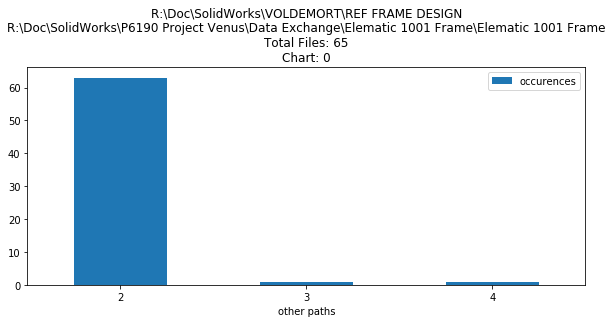

In [1167]:
for i in range(len(numlist_list)):
    titleB = top_offenders2[i]
    chart_em(numlist_list[i], occurlist_list[i], totalFiles_list[i], titleA, titleB, i)

In [1168]:
############################################
# choose chart num and column for file list
############################################
chart_num = 0
quant = 2

In [1169]:
occurence_list, path_list, file_paths_trimmed = build_data2(num, chart_num, top_offenders, top_offenders2, file_paths)

In [1182]:
occurence_list

[63, 63]

In [1183]:
path_list

['R:\\Doc\\SolidWorks\\VOLDEMORT\\REF FRAME DESIGN',
 'R:\\Doc\\SolidWorks\\P6190 Project Venus\\Data Exchange\\Elematic 1001 Frame\\Elematic 1001 Frame']

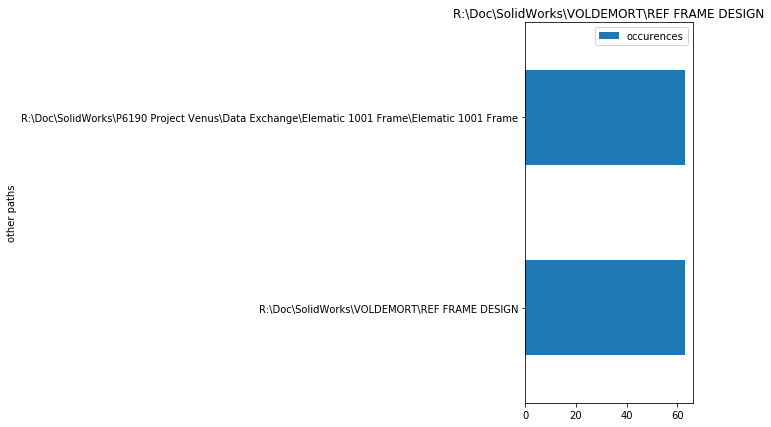

In [1170]:
chart_em2(path_list, occurence_list, titleA)

In [1171]:
############################################
# choose path to maintain, all others will be deleted
############################################
choose_path2 = 1

print(path_list[choose_path2])

file_list = []
for i in path_list:
    if i != path_list[choose_path2]:
        for k, v in file_paths_trimmed.items():
            if i in v:
                file_and_path = i + '\\' + k
                file_list.append(file_and_path)
                
batch2(file_list)

R:\Doc\SolidWorks\P6190 Project Venus\Data Exchange\Elematic 1001 Frame\Elematic 1001 Frame


In [1172]:
# PRINT ALL PATHS
for i in range(len(path_list)):
    print(f'{i} - {path_list[i]}')

0 - R:\Doc\SolidWorks\VOLDEMORT\REF FRAME DESIGN
1 - R:\Doc\SolidWorks\P6190 Project Venus\Data Exchange\Elematic 1001 Frame\Elematic 1001 Frame


In [1173]:
############################################
# choose path to delete from
############################################
choose_path = 0
os.chdir('H:/temp/data_cleanse_batch_files')
files_to_remove = []
path = path_list[choose_path]
for k, v in file_paths_trimmed.items():
    if path_list[choose_path] in v:
        files_to_remove.append(k)
# print(path)
# for i in files_to_remove:
#     print(i)
    
# uncomment below to generate output file
# batch(files_to_remove, path)

# change directory back
os.chdir('C:\\Users\\WDG1DCR\\Desktop\\my_projects\\data_analysis\\data_cleanse')

In [1174]:
file_list = []
for k in file_paths_trimmed.keys():
    file_list.append(k)

In [1175]:
dups_trimmed = dups[dups['name_low'].isin(file_list)]

In [1176]:
for i in range(len(dups_trimmed['size'])):    
    value1 = dups_trimmed['size'].iloc[i]
    value1 = value1.replace(',','')
    value1 = int(value1)
    dups_trimmed['size'].iloc[i] = value1

C:\Users\WDG1DCR\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [1177]:
dups_trimmed = dups_trimmed.sort_values(by=['size'], ascending=False)

In [1178]:
dups_trimmed.reset_index(inplace=True, drop=True)

In [1179]:
# dups_trimmed.head()

In [1180]:
#sorted by size
len(dups_trimmed['Name'])

126

In [1181]:
for i in dups_trimmed['name_low'].unique():
    print(i)

86940.062.sldprt
86940.079.sldprt
86940.076.sldprt
86940.078.sldprt
86004.755.sldprt
86940.028.sldprt
86004.800.sldprt
86940.024.sldprt
86004.803.sldprt
86940.053.sldprt
86940.046.sldprt
86004.751.sldprt
86940.075.sldprt
86940.038.sldprt
86004.812.sldprt
86940.031.sldprt
86940.065.sldasm
86940.052.sldprt
86940.025.sldprt
86940.037.sldprt
86004.760.sldprt
b0045.436.sldprt
86940.077.sldasm
86940.035.sldasm
86940.058.sldprt
86940.072.sldprt
86940.059.sldprt
86940.027.sldasm
86004.752.sldprt
86940.033.sldprt
86940.030.sldprt
86940.026.sldasm
86940.029.sldprt
86940.036.sldasm
86004.784.sldprt
86940.061.sldasm
sechskantschraube din 933 m6x16 b0008.282.sldprt
86940.064.sldprt
86004.758.sldasm
86940.023.sldprt
86940.032.sldprt
86940.048.sldasm
86940.054.sldasm
86940.063.sldprt
86004.785.sldprt
86940.041.sldasm
sechskantschraube din 933 m8x25 b0007.555.sldprt
sechskantschraube din 933 m8x20 b0008.523.sldprt
sechskantschraube din 933 m10x25 b007.442.sldprt
86940.040.sldprt
86940.074.sldasm
86940